# PPI

### Essentials

In [1]:
import numpy as np
import pandas as pd
import string

In [2]:
rng_seed=42

In [3]:
# Seed the numpy RNG to get reproducible results
np.random.seed(rng_seed)

### Biological data processing

In [4]:
from Bio import SeqIO

### Keras preprocessing

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

/home/frgon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Keras training

In [6]:
import keras.backend as K
from keras.models import Model, Sequential
from keras import layers
from keras.layers import Input, Flatten, Reshape, Maximum, BatchNormalization, Dropout, Concatenate, Activation, Lambda
from keras.layers import Embedding, Dense, GlobalMaxPooling1D
from keras.layers import SimpleRNN, RNN, SimpleRNNCell, GRUCell, LSTMCell, LSTM, GRU, CuDNNGRU, CuDNNLSTM
from keras import optimizers
from keras import losses
from keras import regularizers
from keras import callbacks
from keras.models import load_model

### Metrics and plotting

In [7]:
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as skmetrics
import matplotlib
import matplotlib.pyplot as plt
import itertools

# Load the PPI data from the csv

In [8]:
%%time
df_PPI_yeast_dataset = pd.read_csv("interaction_protein_dset.csv")

CPU times: user 23.6 ms, sys: 0 ns, total: 23.6 ms
Wall time: 22.6 ms


# Load the protein sequence database


In [9]:
%%time
uniprot_db = SeqIO.to_dict(SeqIO.parse("uniprot-reviewed.fasta", "fasta"))

CPU times: user 6.82 s, sys: 288 ms, total: 7.11 s
Wall time: 7.11 s


# Preprocess the protein database

### Get the sequences for each aminoacid

In [10]:
%%time
uniprot_db_dict = {}
for key in uniprot_db.keys():
    # Since we only want to search by the code, change the dictionary keys to match our format
    # Get the substring between the two | |
    new_key = key[key.find('|')+1:key.rfind('|')]
    # Also, we just want the sequence, so save it alone (instead of the full record)
    uniprot_db_dict[new_key] = str(uniprot_db[key].seq)

CPU times: user 894 ms, sys: 12.1 ms, total: 906 ms
Wall time: 905 ms


In [11]:
df_PPI_yeast_dataset

,proteinA,proteinB,interaction
0,P09798,P09798,1
1,P38717,P06782,1
2,P07342,P25605,1
3,P15790,P38930,1
4,P22035,P07269,1
5,P33418,P50278,1
6,P14922,P27705,1
7,P05453,P05453,1
8,P12385,P05453,1
9,P19262,P09624,1


In [12]:
df_PPI_yeast_dataset_processed = df_PPI_yeast_dataset

In [13]:
df_PPI_yeast_dataset_processed = df_PPI_yeast_dataset_processed.assign(proteinA_seq = [uniprot_db_dict[prot_id] for prot_id in df_PPI_yeast_dataset_processed['proteinA'].values])

In [14]:
df_PPI_yeast_dataset_processed = df_PPI_yeast_dataset_processed.assign(proteinB_seq = [uniprot_db_dict[prot_id] for prot_id in df_PPI_yeast_dataset_processed['proteinB'].values])

### Generate the ngram sequences from the raw amino acid sequences

In [15]:
n_gram_len = 3
ngram_overlap = 3

In [16]:
def generate_ngram_list(input_seq, n, overlap_step):
    n=1 if n<1 else n
    overlap_step=1 if overlap_step<1 else overlap_step
    # Reverse input
    input_seq = input_seq[::-1]
    output = [input_seq[ii:ii+n] for ii in np.arange(0, len(input_seq), overlap_step)]
    while(len(output[-1]) != n):
        output.pop()
    # Reverse output
    output[:] = output[::-1]
    return output

In [17]:
def generate_ngram_seq(input_seq, n, overlap_step):
    ngram_list = generate_ngram_list(input_seq, n, overlap_step)
    # Reverse each sequences as well
    output = (''.join([' %s' % (ngram[::-1]) for ngram in ngram_list]))
    return output

In [18]:
def generate_ngram_dictionary(n, source_dict):
    unique_symbols = len(source_dict)
    unique_ngrams = unique_symbols**n
    ngram_matrix=np.empty((unique_ngrams,n), dtype='U1')
    
    for ii in np.arange(n):
        change_freq = unique_symbols**(n-ii-1)
        symbol_idx = 0
        for jj in np.arange(0, unique_ngrams, change_freq):
            ngram_matrix[jj:(jj+change_freq), ii] = source_dict[symbol_idx]
            symbol_idx+=1
            if(symbol_idx == unique_symbols):
                symbol_idx=0
            
    # Reduce the second axis
    ngram_list = [ ''.join(symbol) for symbol in [l for l in ngram_matrix]]
    return ngram_list

In [19]:
%%time
aminoacid_dictionary = []
for seq in df_PPI_yeast_dataset_processed.proteinA_seq.values:
    for symbol in list(seq):
        if(not symbol in aminoacid_dictionary):
            aminoacid_dictionary.append(symbol)

CPU times: user 6.54 s, sys: 0 ns, total: 6.54 s
Wall time: 6.54 s


In [20]:
print(len(aminoacid_dictionary), aminoacid_dictionary)

20 ['M', 'K', 'F', 'C', 'L', 'Y', 'H', 'I', 'V', 'G', 'A', 'T', 'S', 'N', 'R', 'P', 'E', 'Q', 'D', 'W']


In [21]:
%%time
ngram_dict = generate_ngram_dictionary(n_gram_len, aminoacid_dictionary)
print(ngram_dict[:10])

['MMM', 'MMK', 'MMF', 'MMC', 'MML', 'MMY', 'MMH', 'MMI', 'MMV', 'MMG']
CPU times: user 20.1 ms, sys: 0 ns, total: 20.1 ms
Wall time: 19.9 ms


In [22]:
%%time
df_PPI_yeast_dataset_processed = df_PPI_yeast_dataset_processed.assign(proteinA_ngramseq = [generate_ngram_seq(prot_seq, n_gram_len, ngram_overlap) for prot_seq in df_PPI_yeast_dataset_processed['proteinA_seq'].values])
df_PPI_yeast_dataset_processed = df_PPI_yeast_dataset_processed.assign(proteinB_ngramseq = [generate_ngram_seq(prot_seq, n_gram_len, ngram_overlap) for prot_seq in df_PPI_yeast_dataset_processed['proteinB_seq'].values])

CPU times: user 12.5 s, sys: 165 ms, total: 12.7 s
Wall time: 12.5 s


### Get a list of the unique symbols that appear in the sequences

In [23]:
%%time
# Get all unique trigrams
ngram_dictionary_A = np.unique([generate_ngram_list(prot_seq, n_gram_len, ngram_overlap) for prot_seq in df_PPI_yeast_dataset_processed['proteinA_seq'].values])[0]
ngram_dictionary_B = np.unique([generate_ngram_list(prot_seq, n_gram_len, ngram_overlap) for prot_seq in df_PPI_yeast_dataset_processed['proteinB_seq'].values])[0]
ngram_dictionary = np.unique(np.concatenate([ngram_dictionary_A, ngram_dictionary_B]))
ngram_dictionary

CPU times: user 12.1 s, sys: 453 ms, total: 12.6 s
Wall time: 12.6 s


# Prepare the training data

In [24]:
df_PPI_yeast_dataset_processed

,proteinA,proteinB,interaction,proteinA_seq,proteinB_seq,proteinA_ngramseq,proteinB_ngramseq
0,P09798,P09798,1,MKFCLYCCHCYIVICGKATHYYKSSKATSNLKSSNRVLMRNPMSPS...,MKFCLYCCHCYIVICGKATHYYKSSKATSNLKSSNRVLMRNPMSPS...,MKF CLY CCH CYI VIC GKA THY YKS SKA TSN LKS S...,MKF CLY CCH CYI VIC GKA THY YKS SKA TSN LKS S...
1,P38717,P06782,1,MSVHGRDPKKRQLRLISVAFKEASIDSPSFRASVNFFQTRVDALED...,MSSNNNTNTAPANANSSHHHHHHHHHHHHHGHGGSNSTLNNPKSSL...,VHG RDP KKR QLR LIS VAF KEA SID SPS FRA SVN F...,MSS NNN TNT APA NAN SSH HHH HHH HHH HHH GHG G...
2,P07342,P25605,1,MIRQSTLKNFAIKRCFQHIAYRNTPAMRSVALAQRFYSSSSRYYSA...,MLRSLLQSGHRRVVASSCATMVRCSSSSTSALAYKQMHRHATRPPL...,MIR QST LKN FAI KRC FQH IAY RNT PAM RSV ALA Q...,MLR SLL QSG HRR VVA SSC ATM VRC SSS STS ALA Y...
3,P15790,P38930,1,MKCRVWSEARVYTNINKQRTEEYWDYENTVIDWSTNTKDYEIENKV...,MGSRSENVGTVTREGSRVEQDDVLMDDDSDSSEYVDMWIDLFLGRK...,MKC RVW SEA RVY TNI NKQ RTE EYW DYE NTV IDW S...,MGS RSE NVG TVT REG SRV EQD DVL MDD DSD SSE Y...
4,P22035,P07269,1,MSNISTKDIRKSKPKRGSGFDLLEVTESLGYQTHRKNGRNSWSKDD...,MMEEFSYDHDFNTHFATDLDYLQHDQQQQQQQQHDQQHNQQQQPQP...,SNI STK DIR KSK PKR GSG FDL LEV TES LGY QTH R...,MEE FSY DHD FNT HFA TDL DYL QHD QQQ QQQ QQH D...
5,P33418,P50278,1,MLERIQQLVNAVNDPRSDVATKRQAIELLNGIKSSENALEIFISLV...,MTTTVPKVFAFHEFAGVAEAVADHVIHAQNSALKKGKVSRSTQMSG...,ERI QQL VNA VND PRS DVA TKR QAI ELL NGI KSS E...,MTT TVP KVF AFH EFA GVA EAV ADH VIH AQN SAL K...
6,P14922,P27705,1,MNPGGEQTIMEQPAQQQQQQQQQQQQQQQQAAVPQQPLDPLTQSTA...,MQSPYPMTQVSNVDDGSLLKESKSKSKVAAKSEAPRPHACPICHRA...,MNP GGE QTI MEQ PAQ QQQ QQQ QQQ QQQ QQQ AAV P...,MQS PYP MTQ VSN VDD GSL LKE SKS KSK VAA KSE A...
7,P05453,P05453,1,MSDSNQGNNQQNYQQYSQNGNQQQGNNRYQGYQAYNAQAQPAGGYY...,MSDSNQGNNQQNYQQYSQNGNQQQGNNRYQGYQAYNAQAQPAGGYY...,SDS NQG NNQ QNY QQY SQN GNQ QQG NNR YQG YQA Y...,SDS NQG NNQ QNY QQY SQN GNQ QQG NNR YQG YQA Y...
8,P12385,P05453,1,MDNEVEKNIEIWKVKKLVQSLEKARGNGTSMISLVIPPKGQIPLYQ...,MSDSNQGNNQQNYQQYSQNGNQQQGNNRYQGYQAYNAQAQPAGGYY...,NEV EKN IEI WKV KKL VQS LEK ARG NGT SMI SLV I...,SDS NQG NNQ QNY QQY SQN GNQ QQG NNR YQG YQA Y...
9,P19262,P09624,1,MLSRATRTAAAKSLVKSKVARNVMAASFVKRHASTSLFKQANKVES...,MLRIRSLLNNKRAFSSTVRTLTINKSHDVVIIGGGPAGYVAAIKAA...,LSR ATR TAA AKS LVK SKV ARN VMA ASF VKR HAS T...,LRI RSL LNN KRA FSS TVR TLT INK SHD VVI IGG G...


### Explore the lengths of the training set

In [25]:
lA = np.array([int(3*len(p)/4) for p in df_PPI_yeast_dataset_processed.proteinA_ngramseq.values])
lB = np.array([int(3*len(p)/4) for p in df_PPI_yeast_dataset_processed.proteinB_ngramseq.values])

In [26]:
np.histogram(np.concatenate([lA,lB]), bins=[0,50,100,200,300,500,800,1000,1500,2000,3000,4000,5000])

(array([    0,  2697, 15153, 20700, 37957, 30059, 11034, 10589,  2348,
         1038,   111,    16]),
 array([   0,   50,  100,  200,  300,  500,  800, 1000, 1500, 2000, 3000,
        4000, 5000]))

## We want to clip the sequences at 1000 max length.

In [27]:
maxlength=1000

In [28]:
source_xA = df_PPI_yeast_dataset_processed.proteinA_ngramseq
source_xB = df_PPI_yeast_dataset_processed.proteinB_ngramseq
num_words_dict = len(ngram_dict)

# Preprocess the sequences

#### Lets define a function to preprocess end to end

In [29]:
%%time
train_tk = Tokenizer(num_words=num_words_dict, char_level=False)
# Fit to all the sequences (both from proteinA and proteinB)
train_tk.fit_on_texts(np.concatenate([source_xA.values, source_xB.values], axis=0))

CPU times: user 13.1 s, sys: 0 ns, total: 13.1 s
Wall time: 13.1 s


#### Quick look at the behaviour of pad_sequences

In [30]:
np.arange(1,6)

array([1, 2, 3, 4, 5])

In [31]:
pad_sequences([np.arange(1,6)],maxlen=10, padding='pre', truncating='pre')

array([[0, 0, 0, 0, 0, 1, 2, 3, 4, 5]], dtype=int32)

In [32]:
np.arange(1,16)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [33]:
pad_sequences([np.arange(1,16)],maxlen=10, padding='pre', truncating='pre')

array([[ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15]], dtype=int32)

#### This function tokenizes the input (translate trigrams to tokens) and pads and truncates the sequences to the same size

In [34]:
def preprocess_data(data_A, data_B, tokenizer, maxlen = maxlength):
    # Tokenize the input
    # Get the sequences of codes (numbers representing a letter)
    seq_A = tokenizer.texts_to_sequences(data_A)
    seq_B = tokenizer.texts_to_sequences(data_B)
    # Pad the sequences to the max length
    padded_seq_A = pad_sequences(seq_A, maxlen=maxlen, padding='pre', truncating='pre')
    padded_seq_B = pad_sequences(seq_B, maxlen=maxlen, padding='pre', truncating='pre')
    
    return padded_seq_A, padded_seq_B

In [35]:
%%time
# Use the function to preprocess the data from the data source of choice
valid_xA, valid_xB = preprocess_data(source_xA.values, source_xB.values, train_tk, maxlength)
valid_label = df_PPI_yeast_dataset_processed.interaction.values

CPU times: user 11.8 s, sys: 425 ms, total: 12.2 s
Wall time: 10.7 s


### First, a few helper functions to assist the testing

In [36]:
%matplotlib inline

np.set_printoptions(precision=2)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [37]:
# Function to evaluate a dataset
# Metrics: Accuracy Precision Recall F1 AUC
# The true labels are expected to be from to_categorical(true_labels)
def evaluate_dset(input_data_protA, input_data_protB, input_true_labels, input_model):
    pY = input_model.predict([input_data_protA, input_data_protB], verbose=1, batch_size=b_size)
    pred_label = np.argmax(pY, axis=1)
    if((len(input_true_labels.shape)) == 2):
        true_label = np.argmax(input_true_labels, axis=1)
    else:
        true_label = input_true_labels
    
    cm = skmetrics.confusion_matrix(true_label, pred_label)
    accuracy = (cm[0,0]+cm[1,1]) / np.sum(cm)
    # TP / (TP + FP)
    precision = cm[1,1] / np.sum(cm[:,1])
    # TP / (TP + FN)
    recall = cm[1,1] / np.sum(cm[1,:])
    # TN / (TN+FP)
    specificity = cm[0,0] / np.sum(cm[:,0])
    f1_score = skmetrics.f1_score(true_label, pred_label)
    mcc_score = skmetrics.matthews_corrcoef(true_label, pred_label)
    auc_score=0
    if(len(np.unique(true_label)) == 2):
        auc_score = skmetrics.roc_auc_score(true_label, pY[:,1])
    dist_to_true_labels = np.float32(true_label) - np.float32(pY[:,1])
    dist_to_true_labels = np.absolute(dist_to_true_labels)
    
    print("Accuracy: %f" % accuracy)
    print("Precision: %f" % precision)
    print("Recall: %f" % recall)
    print("Specificity: %f" % specificity)
    print("MCC: %f" % mcc_score)
    print("AUC: %f" % auc_score)
    print("F1 Score: %f" % f1_score)
    print("Distance to true labels: %f +- %f" % (np.mean(dist_to_true_labels), np.std(dist_to_true_labels)))
    
    plot_confusion_matrix(cm, classes=['0','1'], normalize=True)
    
    return cm, accuracy, precision, recall, specificity, mcc_score, auc_score, f1_score, np.mean(dist_to_true_labels), np.std(dist_to_true_labels) 

In [38]:
def process_results(res_list, res_names=None):
    if(res_names is None):
        res_names = ["Accuracy", "Precision", "Recall", "Specificity", "MCC", "AUC", "F1", "Distance to GT(mean)", "Distance to GT(stdev)"]
    
    # Skip the confusion matrix
    res_array = np.array([res[1:] for res in res_list])
    
    mean_results = np.mean(res_array, axis=0)
    std_results = np.std(res_array, axis=0)
    for ii in np.arange(len(res_names)-2):
        print("%s: %f +- %f" % (res_names[ii], mean_results[ii]*100, std_results[ii]*100))
    # Quick and dirty fix :(
    print("%s: %f +- %f" % (res_names[-2], mean_results[-2], std_results[-2]))
    print("%s: %f +- %f" % (res_names[-1], mean_results[-1], std_results[-1]))

# Build the model

#### Set a few parameters for the networks

In [39]:
# Parameters
nb_epochs = 30
b_size = 128
init_lr = 0.001
val_split = 0.1


embedding_output_dim = 512
drop_rate = 0.2
weight_decay = wd = 0.0001
do_order_decorrelation = False

### Replicate the first experiment
#### Generate 5 different datasets, where a static test using 25% of the data will be performed

In [40]:
def fc_block(input_tensor, features, activation_f='relu', wd=0.0001):
    output = Dense(features,
                   activation='linear',
                   kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(wd),
                   use_bias=False)(input_tensor)
    output = BatchNormalization(axis=1)(output)
    output = Activation(activation_f)(output)
    
    return output

In [41]:
def recurrent_block(input_tensor, recurrent_layer, features, return_sequences=False, wd=0.0001):
    output = input_tensor
    output = recurrent_layer(units=features, 
                        #kernel_regularizer=regularizers.l2(wd), 
                        #recurrent_regularizer=regularizers.l2(wd), 
                        #activity_regularizer=regularizers.l2(wd), 
                        return_sequences=return_sequences)(output)
    output = BatchNormalization(axis=1)(output)
    
    return output

In [42]:
def sequence_feat_extractor(input_tensor, recurrent_layer, return_sequences=False, wd=0.0001):
    output = input_tensor
    output = recurrent_block(output, recurrent_layer, 64, return_sequences=return_sequences)
    return output

In [43]:
def branch_extractor(input_tensor, dropout_rate=0.5):
    output = input_tensor
    output = sequence_feat_extractor(output, CuDNNGRU, return_sequences=False)
    output = fc_block(output, 64, activation_f='elu')
    output = Dropout(dropout_rate)(output)
    return output

In [44]:
def NN(input_dict_nwords):
    input_A = Input(batch_shape=(None, maxlength))
    input_B = Input(batch_shape=(None, maxlength))
    
    shared_embedding = Embedding(input_dim = input_dict_nwords, 
                         output_dim = embedding_output_dim, 
                         input_length=maxlength
                         , embeddings_regularizer=regularizers.l2(wd)
                        )
    # Process branch A
    output_A = input_A
    output_A = shared_embedding(output_A)
    output_A = BatchNormalization(axis=1)(output_A)
    output_A = branch_extractor(output_A)
    
    # Process branch B
    output_B = input_B
    output_B = shared_embedding(output_B)
    output_B = BatchNormalization(axis=1)(output_B)
    output_B = branch_extractor(output_B)
    
    # Merge branches
    output = Concatenate(axis=1)([output_A, output_B])
    # Process merged branch
    output = fc_block(output, 512, activation_f='elu')
    
    # Output layer (binary)
    output = Dense(units=2
                   , activation='softmax'
                   , use_bias=True
                   , kernel_initializer='he_normal'
                   , kernel_regularizer=regularizers.l2(wd)
                   , bias_regularizer=regularizers.l2(wd)
                  )(output)
    
    model = Model([input_A, input_B], outputs=output)
    
    return model

In [45]:
NN(num_words_dict).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 512)    4096000     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1000, 512)    4000        embedding_1[0][0]                
__________

In [46]:
import graphviz

In [47]:
from keras.utils import plot_model
plot_model(NN(num_words_dict))

In [48]:
def decorrelate_order(input_A, input_B, input_labels, random_seed = None):
    out_A = input_A
    out_B = input_B
    out_labels = input_labels
    # Shuffle the data horizontally (swap some protein pairs to decorrelate the positioning)
    # This will be done by shuffling the data vertically, then exchanging the second half of each vector
    # Shuffle the data
    indices_shuffled = np.random.permutation(out_labels.shape[0])
    out_A = out_A[indices_shuffled]
    out_B = out_B[indices_shuffled]
    out_labels = out_labels[indices_shuffled]

    # Exchange the second half of the samples
    # Labels stay unchanged
    tmp_A = out_A.copy()
    half_index = int(out_A.shape[0]/2)
    out_A = np.concatenate([out_A[:half_index], out_B[half_index:]], axis=0)
    out_B = np.concatenate([out_B[:half_index], tmp_A[half_index:]], axis=0)
    del tmp_A
    
    # Shuffle the data again
    indices_shuffled = np.random.permutation(out_labels.shape[0])
    out_A = out_A[indices_shuffled]
    out_B = out_B[indices_shuffled]
    out_labels = out_labels[indices_shuffled]
    
    return out_A, out_B, out_labels

In [49]:
def generate_dset(input_A, input_B, input_labels, decorrelate=True, random_seed = None):
    
    positive_mask = (valid_label > 0)
    negative_mask = ~positive_mask
    
    positive_indices = np.array(np.nonzero(positive_mask)[0])
    last_positive = np.amax(positive_indices)

    n_positives = last_positive+1
    '''
    # Get the negative indices from the mask
    negative_indices = np.array(np.nonzero(negative_mask)[0])
    # Shuffle them using the random seed
    negative_indices = np.random.RandomState(seed=random_seed).permutation(negative_indices)

    # Keep the first to match the positive indices
    negative_indices = negative_indices[:n_positives]
    '''
    # Shuffle the negative indices and keep the first n_positives to replicate their selection
    negative_indices = np.array(np.nonzero(negative_mask)[0])
    negative_indices = negative_indices[np.random.RandomState(seed=random_seed).permutation(negative_indices.shape[0])]
    negative_indices = negative_indices[:n_positives]
    
    # Now, keep all the positives and the negatives indicated by negative_indices
    dset_xA = np.concatenate([input_A[positive_indices], input_A[negative_indices]], axis=0)
    dset_xB = np.concatenate([input_B[positive_indices], input_B[negative_indices]], axis=0)
    dset_labels = np.concatenate([input_labels[positive_indices], input_labels[negative_indices]], axis=0)
    
    if(decorrelate):
        dset_xA, dset_xB, dset_labels = decorrelate_order(dset_xA, dset_xB, dset_labels)
    
    return dset_xA, dset_xB, dset_labels

In [50]:
# Parameters
nb_epochs = 30
b_size = 128
init_lr = 0.001
val_split = 0.1


embedding_output_dim = 512
drop_rate = 0.2
weight_decay = wd = 0.0001
do_order_decorrelation = False

Iteration: 0
Train on 23296 samples, validate on 2589 samples
Epoch 1/30
23296/23296 [==============================] - 37s 2ms/step - loss: 0.6298 - binary_accuracy: 0.8334 - val_loss: 0.4757 - val_binary_accuracy: 0.8949
Epoch 2/30
23296/23296 [==============================] - 32s 1ms/step - loss: 0.4095 - binary_accuracy: 0.9094 - val_loss: 0.4014 - val_binary_accuracy: 0.9100
Epoch 3/30
23296/23296 [==============================] - 32s 1ms/step - loss: 0.3277 - binary_accuracy: 0.9275 - val_loss: 0.3675 - val_binary_accuracy: 0.9073
Epoch 4/30
23296/23296 [==============================] - 32s 1ms/step - loss: 0.2826 - binary_accuracy: 0.9354 - val_loss: 0.3480 - val_binary_accuracy: 0.9119
Epoch 5/30
23296/23296 [==============================] - 32s 1ms/step - loss: 0.2484 - binary_accuracy: 0.9410 - val_loss: 0.3401 - val_binary_accuracy: 0.9112
Epoch 6/30
23296/23296 [==============================] - 32s 1ms/step - loss: 0.2301 - binary_accuracy: 0.9440 - val_loss: 0.3324 - 

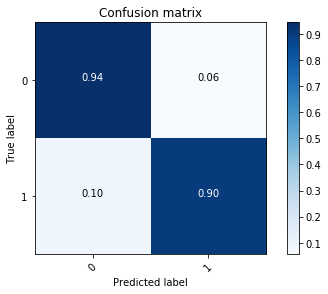

In [51]:
%%time
iteration=0
model_list = []
results_list_0 = []
np.random.seed(rng_seed)

# Training/testing
# Change the repetitions parameter to 30 to replicate the paper results
repetitions = 1

for iteration in np.arange(repetitions):
    np.random.seed(iteration)
    print("Iteration:", iteration)
    # Callbacks
    cb = []
    cb.append(callbacks.ReduceLROnPlateau(monitor='val_loss', patience=0, factor=0.1, min_lr=0.00001,verbose=1))
    cb.append(callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto'))
    cb.append(callbacks.ModelCheckpoint(
        filepath='saved_models/exp_1_base/model_cerevisiae_dset_%d_best_val_acc.hdf5' % (iteration),
        monitor='val_binary_accuracy',
        save_best_only=True,
        verbose=0))
    
    dset_ii_xA, dset_ii_xB, dset_ii_tY = generate_dset(valid_xA,
                                                       valid_xB,
                                                       valid_label,
                                                       decorrelate=do_order_decorrelation,
                                                       random_seed=iteration)
    
    # Now shuffle
    shuffled_indices = np.random.RandomState(seed=iteration).permutation(dset_ii_tY.shape[0])
    dset_ii_xA = dset_ii_xA[shuffled_indices]
    dset_ii_xB = dset_ii_xB[shuffled_indices]
    dset_ii_tY = dset_ii_tY[shuffled_indices]
    
    split_index = int(0.75 * dset_ii_tY.shape[0])
    # Up to the test split index, the test samples
    test_xA = dset_ii_xA[split_index:]
    test_xB = dset_ii_xB[split_index:]
    test_tY = dset_ii_tY[split_index:]
    
    # From the test split index to the end, the training samples
    train_xA = dset_ii_xA[:split_index]
    train_xB = dset_ii_xB[:split_index]
    train_tY = dset_ii_tY[:split_index]
    
    # Get an extra small validation set from the training set (90%). This will be used to stop the training
    val_split = int(train_tY.shape[0] * 0.9)
    val_xA = train_xA[val_split:]
    val_xB = train_xB[val_split:]
    val_tY = train_tY[val_split:]
    
    train_xA = train_xA[:val_split]
    train_xB = train_xB[:val_split]
    train_tY = train_tY[:val_split]

    # Train the model
    K.clear_session()
    model_ii = NN(num_words_dict)
    model_ii.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=init_lr), 
                  metrics=['binary_accuracy'])
    model_ii.fit(x=[train_xA, train_xB],
          y=to_categorical(train_tY, 2), 
          batch_size=b_size,
          epochs=nb_epochs,
          verbose=1,
          validation_data=([val_xA, val_xB], to_categorical(val_tY, 2)),
          callbacks = cb,
          shuffle=True)
    
    results_list_0.append(evaluate_dset(test_xA, test_xB, test_tY, model_ii))
    # Save the scores for comparisons
#     pY = model_ii.predict([test_xA, test_xB], batch_size=b_size)
#     tY = test_tY
#     np.save(file="result_comparison_wilcoxon/mymethod_pred_score_iter_%d"%iteration ,arr=pY)
#     np.save(file="result_comparison_wilcoxon/mymethod_true_score_iter_%d"%iteration ,arr=tY)

In [52]:
process_results(results_list_0)

Accuracy: 92.293429 +- 0.000000
Precision: 94.224778 +- 0.000000
Recall: 90.266299 +- 0.000000
Specificity: 90.484740 +- 0.000000
MCC: 84.667866 +- 0.000000
AUC: 97.281258 +- 0.000000
F1: 92.203072 +- 0.000000
Distance to GT(mean): 0.092907 +- 0.000000
Distance to GT(stdev): 0.232251 +- 0.000000


### Test the model on different datasets

#### First case: *S. Cerevisiae* Core subset

In [53]:
# Read the dataset
s_cerevisiae_core_df = pd.read_csv("test_datasets/Yeast/yeast_protein.csv")
s_cerevisiae_core_df

,id,seq
0,2169,MTASVSNTQNKLNELLDAIRQEFLQVSQEANTYRLQNQKDYDFKMN...
1,1037,MMEEFSYDHDFNTHFATDLDYLQHDQQQQQQQQHDQQHNQQQQPQP...
2,933,MLERIQQLVNAVNDPRSDVATKRQAIELLNGIKSSENALEIFISLV...
3,1355,MQSPYPMTQVSNVDDGSLLKESKSKSKVAAKSEAPRPHACPICHRA...
4,1533,MSDSNQGNNQQNYQQYSQNGNQQQGNNRYQGYQAYNAQAQPAGGYY...
5,1533,MSDSNQGNNQQNYQQYSQNGNQQQGNNRYQGYQAYNAQAQPAGGYY...
6,990,MLRIRSLLNNKRAFSSTVRTLTINKSHDVVIIGGGPAGYVAAIKAA...
7,989,MLRFVSSQTCRYSSRGLLKTSLLKNASTVKIVGRGLATTGTDNFLS...
8,999,MLRSLLQSGHRRVVASSCATMVRCSSSSTSALAYKQMHRHATRPPL...
9,2303,MTTDNAKAQLTSSSGGNIIVVSNRLPVTITKNSSTGQYEYAMSSGG...


In [54]:
# This dataset contains the sequence, and is ordered as follows:
# 5594 protein A, positive
0
pA = 5594
# 5594 protein B, positive
pA
pB = pA+5594
# 5594 protein A, negative
pB
nA = pB+5594
# 5594 protein B, negative
nA
# To end

cerevisiae_core_seq_A = np.concatenate([np.array(s_cerevisiae_core_df.iloc[:pA].seq),
                                        np.array(s_cerevisiae_core_df.iloc[pB:nA].seq)], axis=0)
cerevisiae_core_seq_B = np.concatenate([np.array(s_cerevisiae_core_df.iloc[pA:pB].seq),
                                        np.array(s_cerevisiae_core_df.iloc[nA:].seq)], axis=0)
sc_core_labels = np.zeros((cerevisiae_core_seq_A.shape[0]))
sc_core_labels[:pA] = 1


In [55]:
np.histogram([len(prot) for prot in np.concatenate(
    [cerevisiae_core_seq_A, cerevisiae_core_seq_B])],
    bins=[0,50,500,1000,1500, 2000,3000,4000,5000,9000])

(array([    0, 12506,  7357,  1852,   446,   178,    18,    19,     0]),
 array([   0,   50,  500, 1000, 1500, 2000, 3000, 4000, 5000, 9000]))

In [56]:
# Get the trigrams
cerevisiae_core_ngramseq_A = [generate_ngram_seq(seq, n_gram_len, ngram_overlap) for seq in cerevisiae_core_seq_A]
cerevisiae_core_ngramseq_B = [generate_ngram_seq(seq, n_gram_len, ngram_overlap) for seq in cerevisiae_core_seq_B]

In [57]:
%%time
# Get the token sequences (preprocess the data)
sc_core_xA, sc_core_xB = preprocess_data(cerevisiae_core_ngramseq_A, cerevisiae_core_ngramseq_B, train_tk, maxlength)

CPU times: user 2.93 s, sys: 149 ms, total: 3.08 s
Wall time: 1.88 s


In [58]:
if(do_order_decorrelation):
    sc_core_xA, sc_core_xB, sc_core_labels = decorrelate_order(sc_core_xA, sc_core_xB, sc_core_labels)

In [59]:
# Shuffle
shuffled_indices = np.random.RandomState(seed=42).permutation(len(sc_core_labels))
sc_core_xA = sc_core_xA[shuffled_indices]
sc_core_xB = sc_core_xB[shuffled_indices]
sc_core_labels = sc_core_labels[shuffled_indices]

Iteration 1
Train on 8055 samples, validate on 895 samples
Epoch 1/30
8055/8055 [==============================] - 13s 2ms/step - loss: 0.6509 - categorical_accuracy: 0.8293 - val_loss: 0.4661 - val_categorical_accuracy: 0.9240
Epoch 2/30
8055/8055 [==============================] - 11s 1ms/step - loss: 0.3658 - categorical_accuracy: 0.9471 - val_loss: 0.3971 - val_categorical_accuracy: 0.9318
Epoch 3/30
8055/8055 [==============================] - 11s 1ms/step - loss: 0.2988 - categorical_accuracy: 0.9574 - val_loss: 0.3680 - val_categorical_accuracy: 0.9318
Epoch 4/30
8055/8055 [==============================] - 11s 1ms/step - loss: 0.2499 - categorical_accuracy: 0.9671 - val_loss: 0.3782 - val_categorical_accuracy: 0.9318

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/30
8055/8055 [==============================] - 11s 1ms/step - loss: 0.1999 - categorical_accuracy: 0.9805 - val_loss: 0.3538 - val_categorical_accuracy: 0.9385
Epoch 6/30
805

8055/8055 [==============================] - 11s 1ms/step - loss: 0.1311 - categorical_accuracy: 0.9903 - val_loss: 0.2965 - val_categorical_accuracy: 0.9441
Epoch 16/30
8055/8055 [==============================] - 11s 1ms/step - loss: 0.1283 - categorical_accuracy: 0.9903 - val_loss: 0.2956 - val_categorical_accuracy: 0.9441
Epoch 00016: early stopping
2238/2238 [==============================] - 2s 692us/step
Accuracy: 0.942806
Precision: 0.978744
Recall: 0.905273
Specificity: 0.911887
MCC: 0.888118
AUC: 0.980839
F1 Score: 0.940576
Distance to true labels: 0.066341 +- 0.213082
Normalized confusion matrix
[[0.98 0.02]
 [0.09 0.91]]
Iteration 4
Train on 8055 samples, validate on 895 samples
Epoch 1/30
8055/8055 [==============================] - 13s 2ms/step - loss: 0.6449 - categorical_accuracy: 0.8386 - val_loss: 0.4529 - val_categorical_accuracy: 0.9307
Epoch 2/30
8055/8055 [==============================] - 11s 1ms/step - loss: 0.3712 - categorical_accuracy: 0.9430 - val_loss: 0.39

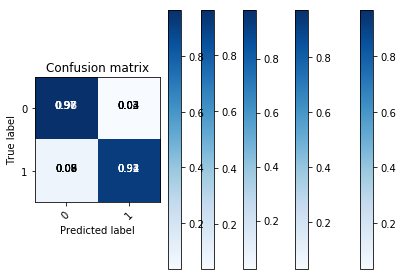

In [60]:
iteration=0
model_list = []
results_list_1 = []
np.random.seed(42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(np.zeros_like(sc_core_labels), sc_core_labels):
    iteration+=1
    print("Iteration %d" % (iteration))
    cb = []
    cb.append(callbacks.ReduceLROnPlateau(monitor='val_loss', patience=0, factor=0.1, min_lr=0.00001,verbose=1))
    cb.append(callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto'))
    cb.append(callbacks.ModelCheckpoint(
        filepath='saved_models/exp_2_sc_core/model_sc_core_cv_%d_best_val_acc.hdf5' % (iteration),
        monitor='val_categorical_accuracy',
        save_best_only=True,
        verbose=0))
    
    train_xA = sc_core_xA[train_idx]
    train_xB = sc_core_xB[train_idx]
    train_tY = sc_core_labels[train_idx]
    
    # Shuffle the training
    shuffled_indices = np.random.permutation(train_tY.shape[0])
    train_xA = train_xA[shuffled_indices]
    train_xB = train_xB[shuffled_indices]
    train_tY = train_tY[shuffled_indices]
    # Get a 10% for training process validation
    val_split = int(train_tY.shape[0] * 0.9)
    val_xA = train_xA[val_split:]
    val_xB = train_xB[val_split:]
    val_tY = train_tY[val_split:]
    
    train_xA = train_xA[:val_split]
    train_xB = train_xB[:val_split]
    train_tY = train_tY[:val_split]

    # Separate the test data
    test_xA = sc_core_xA[test_idx]
    test_xB = sc_core_xB[test_idx]
    test_tY = sc_core_labels[test_idx]
    
    # Train the model
    K.clear_session()
    model_ii = NN(num_words_dict)

    model_ii.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.rmsprop(lr=init_lr), 
                  metrics=['categorical_accuracy'])
    
    model_ii.fit(x=[train_xA, train_xB],
          y=to_categorical(train_tY, 2), 
          batch_size=b_size,
          epochs=nb_epochs,
          verbose=1,
          validation_data=([val_xA, val_xB], to_categorical(val_tY, 2)),
          callbacks = cb,
          shuffle=True)
    
    # Save the model after training
#     model_ii.save("saved_models/exp_2_sc_core/model_sc_core_cv_%d_last_weights.hdf5" % (iteration))
    
    # Evaluate the model (get all metrics, best weights)
    model_ii = best_model_ii = load_model('saved_models/exp_2_sc_core/model_sc_core_cv_%d_best_val_acc.hdf5' % (iteration))
    results_list_1.append(evaluate_dset(test_xA, test_xB, test_tY, model_ii))

In [61]:
process_results(results_list_1)

Accuracy: 94.654952 +- 0.427736
Precision: 96.756545 +- 0.676872
Recall: 92.420414 +- 1.336991
Specificity: 92.765523 +- 1.148321
MCC: 89.415883 +- 0.799479
AUC: 98.397043 +- 0.191245
F1: 94.528840 +- 0.478537
Distance to GT(mean): 0.061562 +- 0.003370
Distance to GT(stdev): 0.202270 +- 0.007595


#### Second case: *H. Pylori* dataset

In [62]:
# Read the dataset
h_pylori_df = pd.read_csv("test_datasets/pylori/pylori_protein.csv")
h_pylori_df

,id,seq
0,106,MATRTQARGAVVELLYAFESGNEEIKKIASSMLEEKKIKNNQLAFA...
1,106,MATRTQARGAVVELLYAFESGNEEIKKIASSMLEEKKIKNNQLAFA...
2,106,MATRTQARGAVVELLYAFESGNEEIKKIASSMLEEKKIKNNQLAFA...
3,1095,MQIIEGKLQLQGNERVAILTSRFNHIITDRLQEGAMDCFKRHGGDE...
4,1095,MQIIEGKLQLQGNERVAILTSRFNHIITDRLQEGAMDCFKRHGGDE...
5,1095,MQIIEGKLQLQGNERVAILTSRFNHIITDRLQEGAMDCFKRHGGDE...
6,1095,MQIIEGKLQLQGNERVAILTSRFNHIITDRLQEGAMDCFKRHGGDE...
7,1112,MQLCVALDLEKKEDNLSLLQELKGLDLWAKVGLRSFIRDGAVFLDE...
8,1112,MQLCVALDLEKKEDNLSLLQELKGLDLWAKVGLRSFIRDGAVFLDE...
9,1112,MQLCVALDLEKKEDNLSLLQELKGLDLWAKVGLRSFIRDGAVFLDE...


In [63]:
# This dataset contains the sequence, and is ordered as follows:
# 1458 protein A, positive
0
pA = 1458
# 1458 protein B, positive
pA
pB = pA+1458
# 1458 protein A, negative
pB
nA = pB+1458
# 1458 protein B, negative
nA
# To end

h_pylori_seq_A = np.concatenate([np.array(h_pylori_df.iloc[:pA].seq),
                                        np.array(h_pylori_df.iloc[pB:nA].seq)], axis=0)
h_pylori_seq_B = np.concatenate([np.array(h_pylori_df.iloc[pA:pB].seq),
                                        np.array(h_pylori_df.iloc[nA:].seq)], axis=0)
hp_labels = np.zeros((h_pylori_seq_A.shape[0]))
hp_labels[:pA] = 1

In [64]:
h_pylori_ngramseq_A = [generate_ngram_seq(seq, n_gram_len, ngram_overlap) for seq in h_pylori_seq_A]
h_pylori_ngramseq_B = [generate_ngram_seq(seq, n_gram_len, ngram_overlap) for seq in h_pylori_seq_B]

In [65]:
np.histogram([len(prot) for prot in np.concatenate(
    [h_pylori_seq_A, h_pylori_seq_B])],
    bins=[0,50,500,1000,1500, 2000,3000,4000,5000,9000])

(array([  91, 4491, 1064,  108,   24,   54,    0,    0,    0]),
 array([   0,   50,  500, 1000, 1500, 2000, 3000, 4000, 5000, 9000]))

In [66]:
%%time
# Get the token sequences (preprocess the data)
hp_xA, hp_xB = preprocess_data(h_pylori_ngramseq_A, h_pylori_ngramseq_B, train_tk, maxlength)

CPU times: user 570 ms, sys: 6.03 ms, total: 576 ms
Wall time: 346 ms


In [67]:
if(do_order_decorrelation):
    hp_xA, hp_xB, hp_labels = decorrelate_order(hp_xA, hp_xB, hp_labels)

In [68]:
# Shuffle
shuffled_indices = np.random.RandomState(seed=42).permutation(len(hp_labels))
hp_xA = hp_xA[shuffled_indices]
hp_xB = hp_xB[shuffled_indices]
hp_labels = hp_labels[shuffled_indices]

Iteration 1
Train on 2098 samples, validate on 234 samples
Epoch 1/30
2098/2098 [==============================] - 5s 2ms/step - loss: 0.8558 - categorical_accuracy: 0.7426 - val_loss: 0.7172 - val_categorical_accuracy: 0.8376
Epoch 2/30
2098/2098 [==============================] - 3s 1ms/step - loss: 0.4433 - categorical_accuracy: 0.9280 - val_loss: 0.8124 - val_categorical_accuracy: 0.7949

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/30
2098/2098 [==============================] - 3s 1ms/step - loss: 0.3345 - categorical_accuracy: 0.9666 - val_loss: 0.7761 - val_categorical_accuracy: 0.8162

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 4/30
2098/2098 [==============================] - 3s 1ms/step - loss: 0.3131 - categorical_accuracy: 0.9728 - val_loss: 0.7628 - val_categorical_accuracy: 0.8205

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 00004: early stopping
584/584 [===

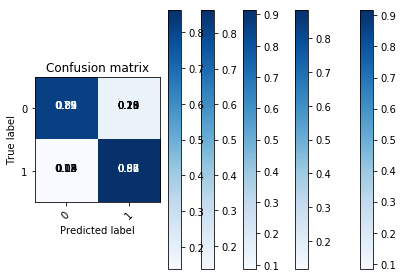

In [69]:
iteration=0
model_list = []
results_list_2 = []
np.random.seed(42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(np.zeros_like(hp_labels), hp_labels):
    iteration+=1
    print("Iteration %d" % (iteration))
    cb = []
    cb.append(callbacks.ReduceLROnPlateau(monitor='val_loss', patience=0, factor=0.1, min_lr=0.00001,verbose=1))
    cb.append(callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto'))
    cb.append(callbacks.ModelCheckpoint(
        filepath='saved_models/exp_3_hp/model_hp_cv_%d_best_val_acc.hdf5' % (iteration),
        monitor='val_categorical_accuracy',
        save_best_only=True,
        verbose=0))
    
    train_xA = hp_xA[train_idx]
    train_xB = hp_xB[train_idx]
    train_tY = hp_labels[train_idx]
    
    # Shuffle the training
    shuffled_indices = np.random.permutation(train_tY.shape[0])
    train_xA = train_xA[shuffled_indices]
    train_xB = train_xB[shuffled_indices]
    train_tY = train_tY[shuffled_indices]
    # Get 10% for training process validation
    val_split = int(train_tY.shape[0] * 0.9)
    val_xA = train_xA[val_split:]
    val_xB = train_xB[val_split:]
    val_tY = train_tY[val_split:]
    
    train_xA = train_xA[:val_split]
    train_xB = train_xB[:val_split]
    train_tY = train_tY[:val_split]

    # Separate the test data
    test_xA = hp_xA[test_idx]
    test_xB = hp_xB[test_idx]
    test_tY = hp_labels[test_idx]
    
    # Train the model
    K.clear_session()
    model_ii = NN(num_words_dict)
    model_ii.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.rmsprop(lr=init_lr), 
                  metrics=['categorical_accuracy'])
    
    model_ii.fit(x=[train_xA, train_xB],
          y=to_categorical(train_tY, 2), 
          batch_size=b_size,
          epochs=nb_epochs,
          verbose=1,
          validation_data=([val_xA, val_xB], to_categorical(val_tY, 2)),
          callbacks = cb,
          shuffle=True)
    
    # Save the model after training
#     model_ii.save("saved_models/exp_2_sc_core/model_sc_core_cv_%d_last_weights.hdf5" % (iteration))
    
    # Evaluate the model (get all metrics, best weights)
    model_ii = best_model_ii = load_model('saved_models/exp_3_hp/model_hp_cv_%d_best_val_acc.hdf5' % (iteration))
    results_list_2.append(evaluate_dset(test_xA, test_xB, test_tY, model_ii))

In [70]:
process_results(results_list_2)

Accuracy: 85.184531 +- 1.274132
Precision: 82.785833 +- 1.421529
Recall: 88.885515 +- 2.338219
Specificity: 88.059239 +- 2.172743
MCC: 70.606478 +- 2.608523
AUC: 92.105522 +- 1.119829
F1: 85.705174 +- 1.291802
Distance to GT(mean): 0.192338 +- 0.026963
Distance to GT(stdev): 0.277702 +- 0.008436


#### Third case: *H. Sapiens* dataset

In [71]:
# Read the dataset
human_df = pd.read_csv("test_datasets/Human/human_protein.csv")
human_df

,id,seq
0,1747,MLSKRGCHARIYADFPIRRLISQRSSLETLEDIEENAPLRRCRTLS...
1,2157,MRKDRLLHLCLVLLLILLSASDSNSTEPQYMVLVPSLLHTEAPKKG...
2,144,MAASETVRLRLQFDYPPPATPHCTAFWLLVDLNRCRVVTDLISLIR...
3,1921,MPGDHRRIRGPEESQPPQLYAADEEEAPGTRDPTRLRPVYARAGLL...
4,2590,MTEGARAADEVRVPLGAPPPGPAALVGASPESPGAPGREAERGSEL...
5,2356,MSGPVPSRARVYTDVNTHRPREYWDYESHVVEWGNQDDYQLVRKLG...
6,33,MAAAPQAPGRGSLRKTRPLVVKTSLNNPYIIRWSALESEDMHFILQ...
7,799,MDDREDLVYQAKLAEQAERYDEMVESMKKVAGMDVELTVEERNLLS...
8,2374,MSHPSWLPPKSTGEPLGHVPARMETTHSFGNPSISVSTQQPPKKFA...
9,1697,MLMPKKNRIAIYELLFKEGVMVAKKDVHMPKHPELADKNVPNLHVM...


In [72]:
# This dataset contains the sequence, and is ordered as follows:
# 3899 protein A, positive
0
pA = 3899
# 3899 protein B, positive
pA
pB = pA+3899
# 4262 protein A, negative
pB
nA = pB+4262
# 4262 protein B, negative
nA
# To end

human_seq_A = np.concatenate([np.array(human_df.iloc[:pA].seq),
                                        np.array(human_df.iloc[pB:nA].seq)], axis=0)
human_seq_B = np.concatenate([np.array(human_df.iloc[pA:pB].seq),
                                        np.array(human_df.iloc[nA:].seq)], axis=0)
human_labels = np.zeros((human_seq_A.shape[0]))
human_labels[:pA] = 1

In [73]:
np.histogram([len(prot) for prot in np.concatenate(
    [human_seq_A, human_seq_B])],
    bins=[0,50,500,1000,1500, 2000,3000,4000,5000,9000])

(array([   1, 9307, 4748, 1336,  370,  356,   55,  112,   29]),
 array([   0,   50,  500, 1000, 1500, 2000, 3000, 4000, 5000, 9000]))

In [74]:
%%time
human_ngram_seq_A = [generate_ngram_seq(seq, n_gram_len, ngram_overlap) for seq in human_seq_A]
human_ngram_seq_B = [generate_ngram_seq(seq, n_gram_len, ngram_overlap) for seq in human_seq_B]

CPU times: user 1.89 s, sys: 2.08 ms, total: 1.89 s
Wall time: 1.88 s


In [75]:
%%time
# Get the token sequences (preprocess the data)
human_xA, human_xB = preprocess_data(human_ngram_seq_A, human_ngram_seq_B, train_tk, maxlength)

CPU times: user 2.35 s, sys: 54.3 ms, total: 2.4 s
Wall time: 1.5 s


In [76]:
if(do_order_decorrelation):
    human_xA, human_xB, human_labels = decorrelate_order(human_xA, human_xB, human_labels)

In [77]:
# Shuffle
shuffled_indices = np.random.RandomState(seed=42).permutation(len(human_labels))
human_xA = human_xA[shuffled_indices]
human_xB = human_xB[shuffled_indices]
human_labels = human_labels[shuffled_indices]

Iteration 1
Train on 5875 samples, validate on 653 samples
Epoch 1/30
5875/5875 [==============================] - 10s 2ms/step - loss: 0.5181 - categorical_accuracy: 0.8980 - val_loss: 0.4512 - val_categorical_accuracy: 0.9449
Epoch 2/30
5875/5875 [==============================] - 8s 1ms/step - loss: 0.2587 - categorical_accuracy: 0.9859 - val_loss: 0.4234 - val_categorical_accuracy: 0.9556
Epoch 3/30
5875/5875 [==============================] - 8s 1ms/step - loss: 0.2024 - categorical_accuracy: 0.9922 - val_loss: 0.4081 - val_categorical_accuracy: 0.9495
Epoch 4/30
5875/5875 [==============================] - 8s 1ms/step - loss: 0.1792 - categorical_accuracy: 0.9893 - val_loss: 0.3222 - val_categorical_accuracy: 0.9648
Epoch 5/30
5875/5875 [==============================] - 8s 1ms/step - loss: 0.1514 - categorical_accuracy: 0.9915 - val_loss: 0.3469 - val_categorical_accuracy: 0.9541

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/30
5875/58

5875/5875 [==============================] - 8s 1ms/step - loss: 0.1541 - categorical_accuracy: 0.9985 - val_loss: 0.3660 - val_categorical_accuracy: 0.9678
Epoch 16/30
5875/5875 [==============================] - 8s 1ms/step - loss: 0.1516 - categorical_accuracy: 0.9991 - val_loss: 0.3644 - val_categorical_accuracy: 0.9709
Epoch 17/30
5875/5875 [==============================] - 8s 1ms/step - loss: 0.1501 - categorical_accuracy: 0.9993 - val_loss: 0.3635 - val_categorical_accuracy: 0.9709
Epoch 18/30
5875/5875 [==============================] - 8s 1ms/step - loss: 0.1496 - categorical_accuracy: 0.9988 - val_loss: 0.3633 - val_categorical_accuracy: 0.9709
Epoch 19/30
5875/5875 [==============================] - 8s 1ms/step - loss: 0.1490 - categorical_accuracy: 0.9985 - val_loss: 0.3626 - val_categorical_accuracy: 0.9709
Epoch 20/30
5875/5875 [==============================] - 8s 1ms/step - loss: 0.1471 - categorical_accuracy: 0.9985 - val_loss: 0.3612 - val_categorical_accuracy: 0.972

Train on 5877 samples, validate on 653 samples
Epoch 1/30
5877/5877 [==============================] - 10s 2ms/step - loss: 0.5422 - categorical_accuracy: 0.8855 - val_loss: 0.4149 - val_categorical_accuracy: 0.9479
Epoch 2/30
5877/5877 [==============================] - 8s 1ms/step - loss: 0.2667 - categorical_accuracy: 0.9852 - val_loss: 0.3970 - val_categorical_accuracy: 0.9510
Epoch 3/30
5877/5877 [==============================] - 8s 1ms/step - loss: 0.2032 - categorical_accuracy: 0.9918 - val_loss: 0.5431 - val_categorical_accuracy: 0.9265

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/30
5877/5877 [==============================] - 8s 1ms/step - loss: 0.1789 - categorical_accuracy: 0.9917 - val_loss: 0.4165 - val_categorical_accuracy: 0.9464

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 5/30
5877/5877 [==============================] - 8s 1ms/step - loss: 0.1636 - categorical_accuracy: 0.9969 - 

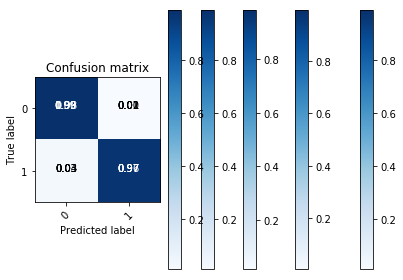

In [78]:
iteration=0
model_list = []
results_list_3 = []
np.random.seed(rng_seed)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng_seed)

for train_idx, test_idx in skf.split(np.zeros_like(human_labels), human_labels):
    iteration+=1
    print("Iteration %d" % (iteration))
    cb = []
    cb.append(callbacks.ReduceLROnPlateau(monitor='val_loss', patience=0, factor=0.1, min_lr=0.00001,verbose=1))
    cb.append(callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto'))
    cb.append(callbacks.ModelCheckpoint(
        filepath='saved_models/exp_4_human/model_human_cv_%d_best_val_acc.hdf5' % (iteration),
        monitor='val_categorical_accuracy',
        save_best_only=True,
        verbose=0))
    
    # Get the training and validation sets
    train_xA = human_xA[train_idx]
    train_xB = human_xB[train_idx]
    train_tY = human_labels[train_idx]
    
    # Finally, set aside the test data (5-fold CV)
    test_xA = human_xA[test_idx]
    test_xB = human_xB[test_idx]
    test_tY = human_labels[test_idx]
    
    # Train the model
    K.clear_session()
    model_ii = NN(num_words_dict)
    model_ii.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.rmsprop(lr=init_lr), 
                  metrics=['categorical_accuracy'])
    
    model_ii.fit(x=[train_xA, train_xB],
          y=to_categorical(train_tY, 2), 
          batch_size=b_size,
          epochs=nb_epochs,
          verbose=1,
          validation_split=0.1,
          callbacks = cb,
          shuffle=True)
    
    # Save the model after training
    model_ii.save("saved_models/exp_4_human/model_human_cv_%d_last_weights.hdf5" % (iteration))
    
    # Evaluate the model (get all metrics, best weights)
    model_ii = best_model_ii = load_model('saved_models/exp_4_human/model_human_cv_%d_best_val_acc.hdf5' % (iteration))
    results_list_3.append(evaluate_dset(test_xA, test_xB, test_tY, model_ii))

In [79]:
process_results(results_list_3)

Accuracy: 97.978166 +- 0.357382
Precision: 98.900584 +- 0.425956
Recall: 96.845463 +- 0.401372
Specificity: 97.168226 +- 0.358635
MCC: 95.964271 +- 0.717450
AUC: 99.629601 +- 0.199814
F1: 97.861944 +- 0.377308
Distance to GT(mean): 0.023079 +- 0.004273
Distance to GT(stdev): 0.127352 +- 0.009415


### Test the model and weights on the 5 cross species datasets

In [80]:
# Load the model that we are going to use to predict
# K.clear_session()
model_species_prediction = load_model('saved_models/exp_1_base/model_cerevisiae_dset_0_best_val_acc.hdf5')

##### 1: *E. Coli*

In [81]:
# Read the dataset
ecoli_species_df = pd.read_csv("test_datasets/cross_species_dataset/ecoli_protein.csv")

In [82]:
# This dataset contains the sequence, and is ordered as follows:
# 6954 protein A, positive
pA = 6954
# 6954 protein B, positive

ecoli_species_A = np.array(ecoli_species_df.iloc[:pA].seq)
ecoli_species_B = np.array(ecoli_species_df.iloc[pA:].seq)
ecoli_species_labels = np.ones((ecoli_species_A.shape[0]))

In [83]:
np.histogram([len(prot) for prot in np.concatenate(
    [ecoli_species_A, ecoli_species_B])],
    bins=[0,50,500,1000,1500, 2000,3000,4000,5000,9000])

(array([    0, 10744,  2736,   406,    14,     8,     0,     0,     0]),
 array([   0,   50,  500, 1000, 1500, 2000, 3000, 4000, 5000, 9000]))

In [84]:
ecoli_species_A = [generate_ngram_seq(seq, n_gram_len, ngram_overlap) for seq in ecoli_species_A]
ecoli_species_B = [generate_ngram_seq(seq, n_gram_len, ngram_overlap) for seq in ecoli_species_B]

In [85]:
%%time
# Get the token sequences (preprocess the data)
ecoli_species_xA, ecoli_species_xB = preprocess_data(ecoli_species_A, ecoli_species_B, train_tk, maxlength)

CPU times: user 1.34 s, sys: 39 ms, total: 1.38 s
Wall time: 837 ms


In [86]:
if(do_order_decorrelation):
    ecoli_species_xA, ecoli_species_xB, ecoli_species_labels = decorrelate_order(ecoli_species_xA, ecoli_species_xB, ecoli_species_labels)

6954/6954 [==============================] - 4s 603us/step
Accuracy: 0.866839
Precision: 1.000000
Recall: 0.866839
Specificity: 0.000000
MCC: 0.000000
AUC: 0.000000
F1 Score: 0.928670
Distance to true labels: 0.161504 +- 0.265144
Normalized confusion matrix
[[ nan  nan]
 [0.13 0.87]]


/home/frgon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/frgon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(array([[   0,    0],
        [ 926, 6028]]),
 0.8668392292205924,
 1.0,
 0.8668392292205924,
 0.0,
 0.0,
 0,
 0.9286704668001848,
 0.16150407,
 0.26514438)

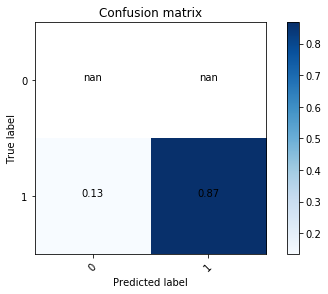

In [87]:
evaluate_dset(ecoli_species_xA, ecoli_species_xB, ecoli_species_labels, model_species_prediction)

6954/6954 [==============================] - 4s 542us/step
Accuracy: 0.866839
Precision: 1.000000
Recall: 0.866839
Specificity: 0.000000
MCC: 0.000000
AUC: 0.000000
F1 Score: 0.928670
Distance to true labels: 0.161504 +- 0.265144
Normalized confusion matrix
[[ nan  nan]
 [0.13 0.87]]


/home/frgon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/frgon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(array([[   0,    0],
        [ 926, 6028]]),
 0.8668392292205924,
 1.0,
 0.8668392292205924,
 0.0,
 0.0,
 0,
 0.9286704668001848,
 0.16150407,
 0.26514438)

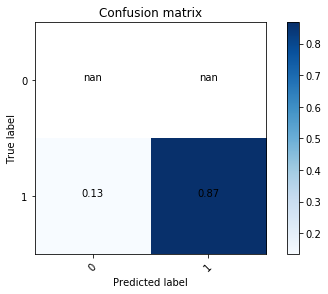

In [88]:
evaluate_dset(ecoli_species_xA, ecoli_species_xB, ecoli_species_labels, model_species_prediction)

##### 2: *C. Elegans*

In [89]:
# Read the dataset
celegans_species_df = pd.read_csv("test_datasets/cross_species_dataset/ecoli_protein.csv")

In [90]:
# This dataset contains the sequence, and is ordered as follows:
# 4013 protein A, positive
pA = 4013
# 4013 protein B, positive

celegans_species_A = np.array(celegans_species_df.iloc[:pA].seq)
celegans_species_B = np.array(celegans_species_df.iloc[pA:].seq)
celegans_species_labels = np.ones((celegans_species_A.shape[0]))

In [91]:
np.histogram([len(prot) for prot in np.concatenate(
    [celegans_species_A, celegans_species_B])],
    bins=[0,50,500,1000,1500, 2000,3000,4000,5000,9000])

(array([    0, 10744,  2736,   406,    14,     8,     0,     0,     0]),
 array([   0,   50,  500, 1000, 1500, 2000, 3000, 4000, 5000, 9000]))

In [92]:
celegans_species_A = [generate_ngram_seq(seq, n_gram_len, ngram_overlap) for seq in celegans_species_A]
celegans_species_B = [generate_ngram_seq(seq, n_gram_len, ngram_overlap) for seq in celegans_species_B]

In [93]:
%%time
# Get the token sequences (preprocess the data)
celegans_species_xA, celegans_species_xB = preprocess_data(celegans_species_A, celegans_species_B, train_tk, maxlength)

CPU times: user 1.39 s, sys: 17.8 ms, total: 1.41 s
Wall time: 828 ms


In [94]:
if(do_order_decorrelation):
    celegans_species_xA, celegans_species_xB, celegans_species_labels = decorrelate_order(celegans_species_xA, celegans_species_xB, celegans_species_labels)

4013/4013 [==============================] - 2s 543us/step
Accuracy: 0.870670
Precision: 1.000000
Recall: 0.870670
Specificity: 0.000000
MCC: 0.000000
AUC: 0.000000
F1 Score: 0.930865
Distance to true labels: 0.154452 +- 0.265296
Normalized confusion matrix
[[ nan  nan]
 [0.13 0.87]]


/home/frgon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/frgon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(array([[   0,    0],
        [ 519, 3494]]),
 0.8706703214552703,
 1.0,
 0.8706703214552703,
 0.0,
 0.0,
 0,
 0.9308645264419874,
 0.15445237,
 0.26529616)

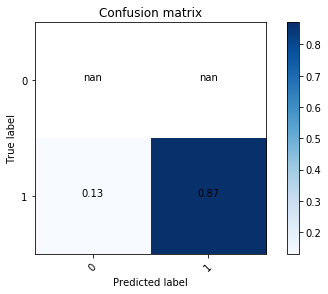

In [95]:
evaluate_dset(celegans_species_xA, celegans_species_xB, celegans_species_labels, model_species_prediction)

##### 3: *H. Sapiens*

In [96]:
# Read the dataset
hsapiens_species_df = pd.read_csv("test_datasets/cross_species_dataset/ecoli_protein.csv")

In [97]:
# This dataset contains the sequence, and is ordered as follows:
# 1412 protein A, positive
pA = 1412
# 1412 protein B, positive

hsapiens_species_A = np.array(hsapiens_species_df.iloc[:pA].seq)
hsapiens_species_B = np.array(hsapiens_species_df.iloc[pA:].seq)
hsapiens_species_labels = np.ones((hsapiens_species_A.shape[0]))

In [98]:
np.histogram([len(prot) for prot in np.concatenate(
    [hsapiens_species_A, hsapiens_species_B])],
    bins=[0,50,500,1000,1500, 2000,3000,4000,5000,9000])

(array([    0, 10744,  2736,   406,    14,     8,     0,     0,     0]),
 array([   0,   50,  500, 1000, 1500, 2000, 3000, 4000, 5000, 9000]))

In [99]:
hsapiens_species_A = [generate_ngram_seq(seq, n_gram_len, ngram_overlap) for seq in hsapiens_species_A]
hsapiens_species_B = [generate_ngram_seq(seq, n_gram_len, ngram_overlap) for seq in hsapiens_species_B]

In [100]:
%%time
# Get the token sequences (preprocess the data)
hsapiens_species_xA, hsapiens_species_xB = preprocess_data(hsapiens_species_A, hsapiens_species_B, train_tk, maxlength)

CPU times: user 1.39 s, sys: 51.1 ms, total: 1.44 s
Wall time: 822 ms


In [101]:
if(do_order_decorrelation):
    hsapiens_species_xA, hsapiens_species_xB, hsapiens_species_labels = decorrelate_order(hsapiens_species_xA, hsapiens_species_xB, hsapiens_species_labels)

1412/1412 [==============================] - 1s 552us/step
Accuracy: 0.875354
Precision: 1.000000
Recall: 0.875354
Specificity: 0.000000
MCC: 0.000000
AUC: 0.000000
F1 Score: 0.933535
Distance to true labels: 0.157411 +- 0.260845
Normalized confusion matrix
[[ nan  nan]
 [0.12 0.88]]


/home/frgon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/frgon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(array([[   0,    0],
        [ 176, 1236]]),
 0.8753541076487252,
 1.0,
 0.8753541076487252,
 0.0,
 0.0,
 0,
 0.9335347432024169,
 0.15741055,
 0.26084495)

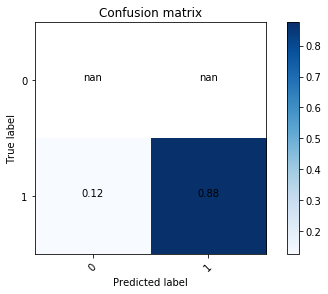

In [102]:
evaluate_dset(hsapiens_species_xA, hsapiens_species_xB, hsapiens_species_labels, model_species_prediction)

##### 4: *H. Pylori*

In [103]:
# Read the dataset
hpylori_species_df = pd.read_csv("test_datasets/cross_species_dataset/ecoli_protein.csv")

In [104]:
# This dataset contains the sequence, and is ordered as follows:
# 1420 protein A, positive
pA = 1420
# 1420 protein B, positive

hpylori_species_A = np.array(hpylori_species_df.iloc[:pA].seq)
hpylori_species_B = np.array(hpylori_species_df.iloc[pA:].seq)
hpylori_species_labels = np.ones((hpylori_species_A.shape[0]))

In [105]:
np.histogram([len(prot) for prot in np.concatenate(
    [hpylori_species_A, hpylori_species_B])],
    bins=[0,50,500,1000,1500, 2000,3000,4000,5000,9000])

(array([    0, 10744,  2736,   406,    14,     8,     0,     0,     0]),
 array([   0,   50,  500, 1000, 1500, 2000, 3000, 4000, 5000, 9000]))

In [106]:
hpylori_species_A = [generate_ngram_seq(seq, n_gram_len, ngram_overlap) for seq in hpylori_species_A]
hpylori_species_B = [generate_ngram_seq(seq, n_gram_len, ngram_overlap) for seq in hpylori_species_B]

In [107]:
%%time
# Get the token sequences (preprocess the data)
hpylori_species_xA, hpylori_species_xB = preprocess_data(hpylori_species_A, hpylori_species_B, train_tk, maxlength)

CPU times: user 1.42 s, sys: 54.5 ms, total: 1.47 s
Wall time: 829 ms


In [108]:
if(do_order_decorrelation):
    hpylori_species_xA, hpylori_species_xB, hpylori_species_labels = decorrelate_order(hpylori_species_xA, hpylori_species_xB, hpylori_species_labels)

1420/1420 [==============================] - 1s 554us/step
Accuracy: 0.870423
Precision: 1.000000
Recall: 0.870423
Specificity: 0.000000
MCC: 0.000000
AUC: 0.000000
F1 Score: 0.930723
Distance to true labels: 0.159488 +- 0.261404
Normalized confusion matrix
[[ nan  nan]
 [0.13 0.87]]


/home/frgon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/frgon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(array([[   0,    0],
        [ 184, 1236]]),
 0.8704225352112676,
 1.0,
 0.8704225352112676,
 0.0,
 0.0,
 0,
 0.9307228915662651,
 0.15948828,
 0.26140398)

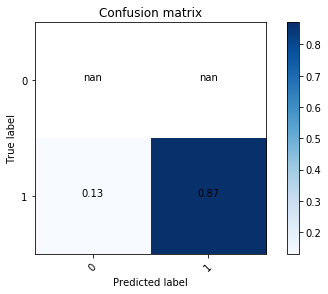

In [109]:
evaluate_dset(hpylori_species_xA, hpylori_species_xB, hpylori_species_labels, model_species_prediction)

1420/1420 [==============================] - 1s 552us/step
Accuracy: 0.870423
Precision: 1.000000
Recall: 0.870423
Specificity: 0.000000
MCC: 0.000000
AUC: 0.000000
F1 Score: 0.930723
Distance to true labels: 0.159488 +- 0.261404
Normalized confusion matrix
[[ nan  nan]
 [0.13 0.87]]


/home/frgon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/frgon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(array([[   0,    0],
        [ 184, 1236]]),
 0.8704225352112676,
 1.0,
 0.8704225352112676,
 0.0,
 0.0,
 0,
 0.9307228915662651,
 0.15948828,
 0.26140398)

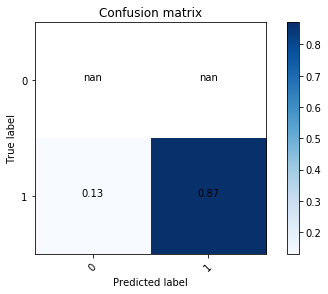

In [110]:
evaluate_dset(hpylori_species_xA, hpylori_species_xB, hpylori_species_labels, model_species_prediction)

##### 5: *M. Musculus*

In [111]:
# Read the dataset
mmusculus_species_df = pd.read_csv("test_datasets/cross_species_dataset/ecoli_protein.csv")

In [112]:
# This dataset contains the sequence, and is ordered as follows:
# 313 protein A, positive
pA = 313
# 313 protein B, positive

mmusculus_species_A = np.array(mmusculus_species_df.iloc[:pA].seq)
mmusculus_species_B = np.array(mmusculus_species_df.iloc[pA:].seq)
mmusculus_species_labels = np.ones((mmusculus_species_A.shape[0]))

In [113]:
np.histogram([len(prot) for prot in np.concatenate(
    [mmusculus_species_A, mmusculus_species_B])],
    bins=[0,50,500,1000,1500, 2000,3000,4000,5000,9000])

(array([    0, 10744,  2736,   406,    14,     8,     0,     0,     0]),
 array([   0,   50,  500, 1000, 1500, 2000, 3000, 4000, 5000, 9000]))

In [114]:
mmusculus_species_A = [generate_ngram_seq(seq, n_gram_len, ngram_overlap) for seq in mmusculus_species_A]
mmusculus_species_B = [generate_ngram_seq(seq, n_gram_len, ngram_overlap) for seq in mmusculus_species_B]

In [115]:
%%time
# Get the token sequences (preprocess the data)
mmusculus_species_xA, mmusculus_species_xB = preprocess_data(mmusculus_species_A, mmusculus_species_B, train_tk, maxlength)

CPU times: user 1.52 s, sys: 99 ms, total: 1.62 s
Wall time: 864 ms


In [116]:
if(do_order_decorrelation):
    mmusculus_species_xA, mmusculus_species_xB, mmusculus_species_labels = decorrelate_order(mmusculus_species_xA, mmusculus_species_xB, mmusculus_species_labels)

313/313 [==============================] - 0s 583us/step
Accuracy: 0.916933
Precision: 1.000000
Recall: 0.916933
Specificity: 0.000000
MCC: 0.000000
AUC: 0.000000
F1 Score: 0.956667
Distance to true labels: 0.123670 +- 0.231442
Normalized confusion matrix
[[ nan  nan]
 [0.08 0.92]]


/home/frgon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/frgon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(array([[  0,   0],
        [ 26, 287]]),
 0.9169329073482428,
 1.0,
 0.9169329073482428,
 0.0,
 0.0,
 0,
 0.9566666666666667,
 0.12366967,
 0.2314424)

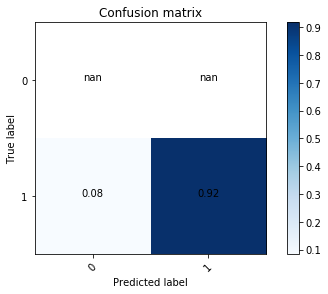

In [117]:
evaluate_dset(mmusculus_species_xA, mmusculus_species_xB, mmusculus_species_labels, model_species_prediction)